# Run ISC

This script finds the networks that exhibit a decrease in ISC over time

## py conversion

In [76]:
#jupyter nbconvert --to python slurm_create-data_preproc.ipynb

## Imports 

In [77]:
import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
import nilearn as nil
# Import a function from BrainIAK to simulate fMRI data
import brainiak.utils.fmrisim as sim  

from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 



from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nilearn import datasets, plotting
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img

from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img

import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

# Brainiak # 
from brainiak import image, io 
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_stat_map
%matplotlib inline

In [78]:
random.seed(10)

## custom helper functions 

## directories 

In [79]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


## main vars 

In [80]:
### sub_list ###
"""

========================================================
===== ~~~ Summary ALL ~~~ ===== 
========================================================
Initially exclude: sub-001, sub-003, sub-011, sub-012, sub-014, sub-015, sub-029 (3+ runs still available tho)
Maybe exclude: sub-014, sub-024, sub-037 (No button presses)
Maybe exclude: sub-020, sub-022, sub-031
total exclude = 10


~~~~~~~ BEHAVIORAL ~~~~~~~~~~
~~~ Summary behavioral ~~~

========================================================
========================================================
No button presses: sub-014, sub-024, sub-037 

========================================================
========================================================
sub-003: Extra row observed for external, which was manually deleted. Should be fine to rerun -- i removed from bad_subs
    - current brushing: 87, TRUE: 88 for THREE runs. last run when there was an issue and scan had to be restarted
    - Scan 6 == 1 run of brushing
    - Scan 7 = 3 runs of brushing 
    - ** no idea when run 7 was started tho! will prolly need to throw out! For now we can process all
sub-014: NO internal OR external bpress, curious! ---should be fixed now
    - changed excel data to include two null columns
    - ALSO only 30 TRs for the second run epi data. i went into the room to adjust runny eyes. Data for this run is not usable. but after should
      be okay if u want to put in the effort 
sub-015: less than 24 runs ---should be fixed now w custom code (but keep out of main run cuz will throw an error otherwise )
    - SUMMARY: need to exclude the office run 3 for fMRI but can include run 3 in behavioral, no data at all for CAKE
    - DID NOT add the 'mov_name' component to the custom code, will need to implment from current iteration
    - **** Use external, ignore internal for now... cuz internal is fuqd. Can preprocess all 7 tho

~~~~~~~ FMRI ~~~~~~~~~~
~~~ Summary fMRI ~~~
sub002: 
 - appended two TRs onto the last run, copied from the third to last TR. should be good to use
sub-003, sub-012, sub-014, sub-015, sub-029: 
 - Five runs usable, will need to incorporate them at some point 
sub-001: external usable - first three runs 

========================================================
========================================================
subject 002: (usable, with adjustment)
    only has 92 INSTEAD OF 94 TRs for the FINAL run of shrek. i think cuz i turned off the scanner
    too soon, which didn't account for 4 TRs of buffer? Yep! end tr is 390, (388, 112179). so duplicate TRs maybe.
    - Temporarily eliminate! or duplicate TRs 
    
sub-003: (usable, 5 runs)
- Scan 6 == 1 run of brushing
- Scan 7 = 3 runs of brushing 
*** need to re-preprocess, then append 6 and 7 together; or just throw out this one cuz idk when scan started

sub-011: (usable)
- not preprocessed 
sub-012 (5 runs usable, one run idk)
- I'll need to post process. It seems that an earbud fell out while reading the directions for run 5 
summary: the fifth run  needs to be discarded. all others are usable.
see the behav data: 
sub_dic['External']['oragami']
{'run-1': {'start_tr': 94, 'end_tr': 188, 'bpress': -1},
 'run-2': {'start_tr': 188, 'end_tr': 282, 'bpress': [100.81657150003593]},
 'run-3': {'start_tr': 282, 'end_tr': 376, 'bpress': [88.26579949003644]},
 'run-4': {'start_tr': 378,
  'end_tr': 472,
  }
- you can see taht the start TR is 94!! that's becuz i had to go into the scan room during the instructions screen.
- this is producing the wrong indexing -- becuz the scan doesn't contain enough TRs according to the behavioral data:
    - run 4 of shrek only has 12 TRs because we start at TR 94.
- im not sure when the scan actually started, but if i wanted to try to include i could 
    set the start TR to 1 -- essentially suggesting that the first TR was collected on the external 'waiting 
    for TR' flip. might as well try at some point, but exclude for now
    - this would involve just subtracting 94 from all start end end TRs i think
See the excel behavioral file for further notes notes
this 

sub-014 - no button press data and 7 runs (5 runs usable, but no bpress)
    - same problem as above -- i went into the scanner room during the instructions period to wipe eyes
    {'run-1': {'start_tr': 237, 'end_tr': 323, 'bpress': -1},
     'run-2': {'start_tr': 329, 'end_tr': 415, 'bpress': -1},
     'run-3': {'start_tr': 417, 'end_tr': 503, 'bpress': -1},
     'run-4': {'start_tr': 509, 'end_tr': 595, 'bpress': -1}}

sub-029: (5 runs usable)
- scanner malfunction, maybe possible to stitch together run 6 cuz i started on the *tenth* TR

========================================================
========================================================
Left handed: (sub-020, sub-022, sub-032)
    - sub-020: also no button presses, appeared to be awake tho
    - sub-022: lefty
    - sub-031: ambidexterious, great data
========================================================
========================================================
"""

## adjusted sublist 
sub_list = [
    'sub-002', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010',
    'sub-013','sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028','sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]
#sub_list = ['sub-002', 'sub-003', 'sub-004', 'sub-005']

###### LOADING VARS #######




## plot by network

### rerun ISC to get raw correlations, not q values

In [81]:
from utils_anal import load_epi_data

In [93]:
## here we just remove the portion of the code that threshholds 
runs = [1, 2, 3, 4]
conditions = ["External"]
mov_list = ['office', 'brushing', 'oragami', 'shrek', 'cake', 'sherlock']
mov_list = [ 'sherlock']
num_parc = 400
vis_dic = {}

In [83]:
cor_dic = {}


In [84]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc)
atlas_filename = dataset.maps
labels = dataset.labels

print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

Atlas ROIs are located in nifti image (4D) at: /usr/people/isaacrc/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


In [86]:
for net_lab in network_labels:
    targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
    print(net_lab)

L VisCent
L VisPeri
L SomMotA
L SomMotB
L DorsAttnA
L DorsAttnB
L SalVentAttnA
L SalVentAttnB
L LimbicB
L LimbicA
L ContA
L ContB
L ContC
L DefaultA
L DefaultB
L DefaultC
L TempPar
R VisCent
R VisPeri
R SomMotA
R SomMotB
R DorsAttnA
R DorsAttnB
R SalVentAttnA
R SalVentAttnB
R LimbicB
R LimbicA
R ContA
R ContB
R ContC
R DefaultA
R DefaultB
R DefaultC
R TempPar


In [87]:
# Load  sample data for resampling
resamp_run = load_epi_data(fmri_prep, 'sub-007', 2, "MNI")
# Load parcellation
d = nib.load(atlas_filename)
atlas_nii = resample_to_img(d, resamp_run, interpolation='nearest')
# Get parcellation fdata
atlas_img = atlas_nii.get_fdata()
# paracellations scheme
print(f'count parc:{len(np.unique(atlas_nii.get_fdata()))}')
print("shape of atlas nii object", atlas_img.shape)



Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


In [88]:
"""
num_parc = 400

# Get labels for parcels in left DMN A network
net_lab = 'R ContC' #'L DefaultB'  #'R ContC' #R DorsAttnB  #R VisPeri  #R SalVentAttnA #'R TempPar' #'L SomMotA'

## Target Conditions
targ_cond = "External"

## movie repetitions ##
#m_reps = 1
targ_run = 1

## Get labels associated with the target network ## 
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
"""

'\nnum_parc = 400\n\n# Get labels for parcels in left DMN A network\nnet_lab = \'R ContC\' #\'L DefaultB\'  #\'R ContC\' #R DorsAttnB  #R VisPeri  #R SalVentAttnA #\'R TempPar\' #\'L SomMotA\'\n\n## Target Conditions\ntarg_cond = "External"\n\n## movie repetitions ##\n#m_reps = 1\ntarg_run = 1\n\n## Get labels associated with the target network ## \ntarg_net = (np.array(networks) == net_lab).nonzero()[0] + 1\n'

In [89]:
# Load in network labels
label_fn = 'brainiak-aperture-isc-data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

In [90]:
## mask image ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [91]:
loaded_int_isc = np.load(f'{isc_dir}/int_isc.npz')
loaded_ext_isc = np.load(f'{isc_dir}/ext_isc.npz')
## get template image #
vis_dic = np.load(f'{isc_dir}/vis_dic_nothresh.npy', allow_pickle=True).item()
bpress_nii = vis_dic['Internal-sherlock-1']

In [94]:
for cond in conditions:
    print(f'START {cond}')
    if cond == "External":
        targ_dic = loaded_ext_isc
    else:
        targ_dic = loaded_int_isc
        
    for run in runs:
        for mov in mov_list:
    
            # select movie and run from loaded data ** account for indexing
            data = targ_dic[mov][...,run - 1,:]
            print('loaded!')
            print(f'{mov} run {run} shape is: {data.shape}')

            # Z-score time series for each voxel
            data = zscore(data, axis=0)

            # Leave-one-out approach
            iscs = isc(data, pairwise=False, tolerate_nans=.8)

            # Check shape of output ISC values
            print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
                  f"left-out subjects and {iscs.shape[1]} voxel(s)")

            # Compute mean ISC (with Fisher transformation)
            mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

            print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
                  f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
                  f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


            # Compute median ISC
            median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                                    axis=0)

            print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
                  f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
                  f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

            # Run bootstrap hypothesis test on ISCs
            n_boot = 5
            observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                                          ci_percentile=95,
                                                          summary_statistic='median',
                                                          n_bootstraps=n_boot)


            # Get number of NaN voxels
            n_nans = np.sum(np.isnan(observed))
            print(f"{n_nans} voxels out of {observed.shape[0]} are NaNs "
                  f"({n_nans / observed.shape[0] * 100:.2f}%)")

            # Get voxels without NaNs
            nonnan_mask = ~np.isnan(observed)
            nonnan_coords = np.where(nonnan_mask)

            # Mask both the ISC and p-value map to exclude NaNs
            nonnan_isc = observed[nonnan_mask]
            nonnan_p = p[nonnan_mask]

            # Get FDR-controlled q-values
            nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
            threshold = .05
            print(f"{np.sum(nonnan_q < threshold)} significant voxels "
                  f"controlling FDR at {threshold}")

            # Threshold ISCs according FDR-controlled threshold
            #nonnan_isc[nonnan_q >= threshold] = np.nan

            # Reinsert thresholded ISCs back into whole brain image
            isc_thresh = np.full(observed.shape, np.nan)
            isc_thresh[nonnan_coords] = nonnan_isc

            # Create empty 3D image and populate
            # with thresholded ISC values
            isc_img = np.full(ref_nii.shape, np.nan)
            isc_img[mask_coords] = isc_thresh

            # Convert to NIfTI image
            isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)
            
            # Save
            vis_dic[f'{cond}-{mov}-{run}'] = isc_nii
            print(f'\nfinish {cond}-{mov}-{run}\n')
            
            np.save(f'{isc_dir}/vis_dic_nothresh.npy', vis_dic)
            
            # DO rois # 
            # Convert to 4d numpy array
            f_dat_4d = isc_nii.get_fdata()
            
            for net_lab in network_labels:
                targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
                print(net_lab)
            
                temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
                if f'{cond}-{mov}-{net_lab}' not in cor_dic:
                    cor_dic[f'{cond}-{mov}-{net_lab}'] = [np.round(np.nanmean(temp),5)]
                else:
                    cor_dic[f'{cond}-{mov}-{net_lab}'].append(np.round(np.nanmean(temp),5))
            

START External
loaded!
sherlock run 1 shape is: (102, 112179, 16)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


ISC values shape = (16, 112179) 
i.e., 16 left-out subjects and 112179 voxel(s)
ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.155; maximum mean ISC across voxels = 0.704
ISC values shape = (112179,) 
i.e., 112179 median value across left-out subjects and 112179 voxel(s)
Minimum median ISC across voxels = -0.173; maximum median ISC across voxels = 0.741


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/brainiak/isc.py:523: RuntimeWarning: Mean of empty slice
  statistic = np.tanh(np.nanmean(np.arctanh(iscs), axis=axis))
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


3309 voxels out of 112179 are NaNs (2.95%)
0 significant voxels controlling FDR at 0.05

finish External-sherlock-1

L VisCent
L VisPeri
L SomMotA
L SomMotB
L DorsAttnA
L DorsAttnB
L SalVentAttnA
L SalVentAttnB
L LimbicB
L LimbicA
L ContA
L ContB
L ContC
L DefaultA
L DefaultB
L DefaultC
L TempPar
R VisCent
R VisPeri
R SomMotA
R SomMotB
R DorsAttnA
R DorsAttnB
R SalVentAttnA
R SalVentAttnB
R LimbicB
R LimbicA
R ContA
R ContB
R ContC
R DefaultA
R DefaultB
R DefaultC
R TempPar
loaded!
sherlock run 2 shape is: (102, 112179, 16)
ISC values shape = (16, 112179) 
i.e., 16 left-out subjects and 112179 voxel(s)
ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.174; maximum mean ISC across voxels = 0.727
ISC values shape = (112179,) 
i.e., 112179 median value across left-out subjects and 112179 voxel(s)
Minimum median ISC across voxels = -0.180; maximum median ISC across voxels = 0.769
3309 voxels out of 112179 

In [41]:
#np.save(f'{isc_dir}/', cor_dic)

[0.05263517465697347,
 0.15439801437229383,
 0.06892767928606282,
 0.13455366417627793,
 0.08458742039426426,
 0.1566598502629107,
 0.052441367595150334,
 0.09952843726099687,
 0.12269208715977484,
 0.19466939521198634]

In [95]:
cor_dic

{'External-sherlock-L VisCent': [0.40114, 0.3223, 0.29959, 0.24123],
 'External-sherlock-L VisPeri': [0.38971, 0.31935, 0.29446, 0.25464],
 'External-sherlock-L SomMotA': [0.32205, 0.25698, 0.22561, 0.1939],
 'External-sherlock-L SomMotB': [0.09218, 0.12386, 0.03953, 0.06725],
 'External-sherlock-L DorsAttnA': [0.14915, 0.12515, 0.09481, 0.09194],
 'External-sherlock-L DorsAttnB': [0.33931, 0.26411, 0.17484, 0.121],
 'External-sherlock-L SalVentAttnA': [0.1917, 0.14118, 0.08638, 0.0757],
 'External-sherlock-L SalVentAttnB': [0.11053, 0.11126, 0.02286, 0.05201],
 'External-sherlock-L LimbicB': [0.13811, 0.1394, 0.09152, 0.10541],
 'External-sherlock-L LimbicA': [0.02806, 0.03661, 0.02139, 0.01663],
 'External-sherlock-L ContA': [0.17584, 0.12761, 0.06411, 0.06344],
 'External-sherlock-L ContB': [0.12278, 0.09176, 0.03452, 0.0509],
 'External-sherlock-L ContC': [0.14241, 0.11514, 0.07869, 0.06294],
 'External-sherlock-L DefaultA': [0.26545, 0.28559, 0.23415, 0.17986],
 'External-sherlock

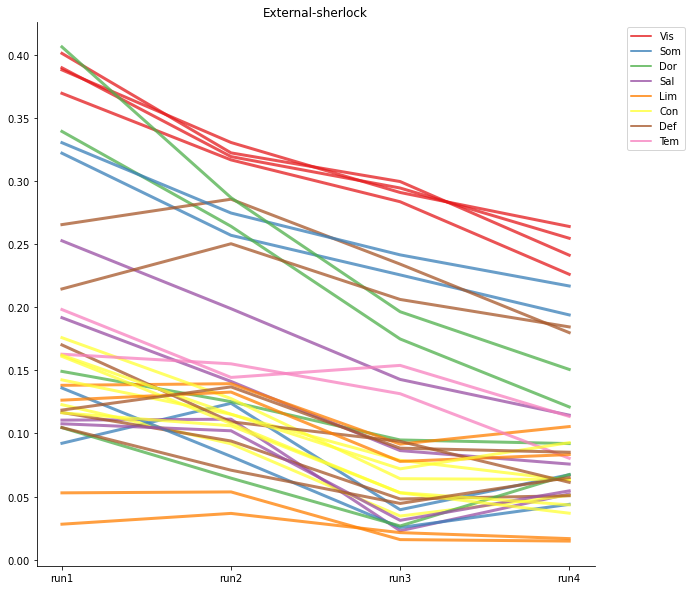

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['run1', 'run2', 'run3', 'run4']

color_mapping = {}
handles = []
for key in cor_dic:
    prefix = key.split()[1][:3]  # Get the prefix of the key
    if prefix not in color_mapping:
        color_mapping[prefix] = sns.color_palette("Set1", n_colors=len(color_mapping) + 1)[len(color_mapping)]
        handles.append(ax.plot([], [], label=prefix, color=color_mapping[prefix])[0])  # Add a dummy line handle for the legend

    ax.plot(cor_dic[key], color=color_mapping[prefix], alpha=0.75, linewidth = 3)

ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.set_title(f'{key.split()[0][:-2]}')

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()


In [43]:
cor_dic

{'Internal-sherlock-L VisCent': [0.2236121385279418,
  0.22361,
  0.22361,
  0.22361,
  0.22361,
  0.22361,
  0.22361,
  0.15409],
 'Internal-sherlock-L VisPeri': [0.21387057344151328,
  0.21387,
  0.21387,
  0.21387,
  0.21387,
  0.21387,
  0.21387,
  0.14048],
 'Internal-sherlock-L SomMotA': [0.20821385509588664,
  0.20821,
  0.20821,
  0.20821,
  0.20821,
  0.20821,
  0.20821,
  0.14883],
 'Internal-sherlock-L SomMotB': [0.07100738059777892,
  0.07101,
  0.07101,
  0.07101,
  0.07101,
  0.07101,
  0.07101,
  0.01581],
 'Internal-sherlock-L DorsAttnA': [0.07531874065888171,
  0.07532,
  0.07532,
  0.07532,
  0.07532,
  0.07532,
  0.07532,
  0.03562],
 'Internal-sherlock-L DorsAttnB': [0.16856301966282053,
  0.16856,
  0.16856,
  0.16856,
  0.16856,
  0.16856,
  0.16856,
  0.12177],
 'Internal-sherlock-L SalVentAttnA': [0.10512764008216213,
  0.10513,
  0.10513,
  0.10513,
  0.10513,
  0.10513,
  0.10513,
  0.06514],
 'Internal-sherlock-L SalVentAttnB': [0.06714855228962405,
  0.06715

In [34]:
data1 = targ_dic['sherlock'][...,0,:]
data2 = targ_dic['sherlock'][...,1,:]

In [35]:
data1.shape

(102, 112179, 17)

In [36]:
data2.shape

(102, 112179, 17)

In [38]:
data1[0,1,1]

14.145326614379883

In [40]:
data2[0,1,1]

5.041234970092773

In [28]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} bootstraps "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0]:.3f},"
      f"\np-value from bootstrap hypothesis test = {p[0]:.3f}")

Null distribution shape = (5, 112179)
i.e., 5 bootstraps and 112179 voxels
Actual observed ISC value for first voxel = -0.032,
p-value from bootstrap hypothesis test = 1.000


In [86]:
cor_dic = {}

In [87]:
# DO rois # 
# Convert to 4d numpy array
f_dat_4d = bpress_nii.get_fdata()

targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
if f'{cond}-{mov}-{net_lab}' not in cor_dic:
    cor_dic[f'{cond}-{mov}-{net_lab}'] = [np.nanmean(temp)]
else:
    cor_dic[f'{cond}-{mov}-{net_lab}'].append(np.nanmean(temp))

In [88]:
cor_dic

{'Internal-office-R ContC': [0.16539153784835273]}

In [77]:
temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]


In [78]:
temp

[0.15212171162661273,
 0.12460714368962275,
 0.17385008319929765,
 0.15132106836969056,
 0.13594276718869874,
 0.17802443846383664,
 0.24187355240071007]

In [41]:
# Convert to 4d numpy array
f_dat_4d = bpress_nii.get_fdata()

targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

# loop through all TRs and get the target voxel pattern #
bpress_pat = np.column_stack([f_dat_4d[atlas_img == parcel].T
                for parcel in targ_net])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 162 and the array at index 1 has size 215

In [37]:
atlas_img.shape

(78, 93, 65)

In [47]:
np.nanmean(f_dat_4d[atlas_img == parcel])

0.24187355240071007

In [42]:
for parcel in targ_net:
    np.column_stack(f_dat_4d[atlas_img == parcel])
    print(parcel)

351
352
353
354
355
356
357


In [52]:
reg_cor = np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])
                for parcel in targ_net])

In [ ]:
cor_dic = {}
runz = [1, 2, 3, 4]


for parcel in targ_net:
    if parcel not in cor_dic:
        cor_dic[parcel] = np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])])
    else:
        cor_dic[parcel].append(np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]))
                        

In [53]:
bpress_pat

0.16539153784835273

In [ ]:
f_dat_4d[]